In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-mri/Brain_MRI/weights.hdf5
/kaggle/input/brain-mri/Brain_MRI/utilities.py
/kaggle/input/brain-mri/Brain_MRI/ResUNet-MRI.json
/kaggle/input/brain-mri/Brain_MRI/resnet-50-MRI.json
/kaggle/input/brain-mri/Brain_MRI/weights_seg.hdf5
/kaggle/input/brain-mri/Brain_MRI/data_mask.csv
/kaggle/input/brain-mri/Brain_MRI/data.csv
/kaggle/input/brain-mri/Brain_MRI/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/brain-mri/Brain_MRI/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/brain-mri/Brain_MRI/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/brain-mri/Brain_MRI/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/brain-mri/Brain_MRI/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/brain-mri/Brain_MRI/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/brain-mri/Brain_MRI/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/brain-mri/Brain_MRI/TCGA_DU_7010_19860307/TCGA

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

In [4]:
brain_df = pd.read_csv('../input/brain-mri/Brain_MRI/data_mask.csv')

In [5]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [6]:
brain_df.head(50)

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0
5,TCGA_CS_5395_19981004,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...,0
6,TCGA_CS_5395_19981004,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...,0
7,TCGA_CS_5395_19981004,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1_...,0
8,TCGA_CS_5395_19981004,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1_...,0
9,TCGA_CS_5395_19981004,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1_...,0


In [7]:
brain_df.mask_path[1] # Path to the brain MRI image

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [8]:
brain_df.image_path[1] # Path to the segmentation mask

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

### To check if we have a balanced dataset

In [9]:
brain_df['mask'].value_counts()
# 0 - HEALTHY
# 1 - TUMOR PRESENCE

0    2556
1    1373
Name: mask, dtype: int64

# **Visualisation**

In [10]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(100,200,0)', marker_line_color = 'rgb(255,0,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

In [11]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [12]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

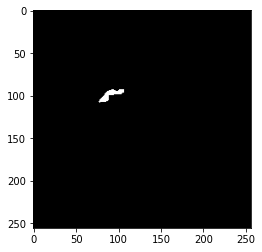

In [14]:
plt.imshow(cv2.imread('../input/brain-mri/Brain_MRI/'+brain_df.mask_path[623]))

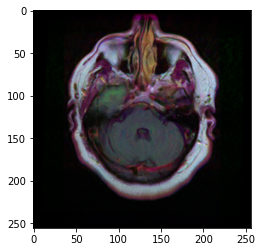

In [15]:
plt.imshow(cv2.imread('../input/brain-mri/Brain_MRI/'+brain_df.image_path[623]))

In [16]:
cv2.imread('../input/brain-mri/Brain_MRI/'+brain_df.mask_path[623]).max()

255

In [17]:
cv2.imread('../input/brain-mri/Brain_MRI/'+brain_df.mask_path[623]).min()

0

## Visualize the images (MRI and Mask) in the dataset separately

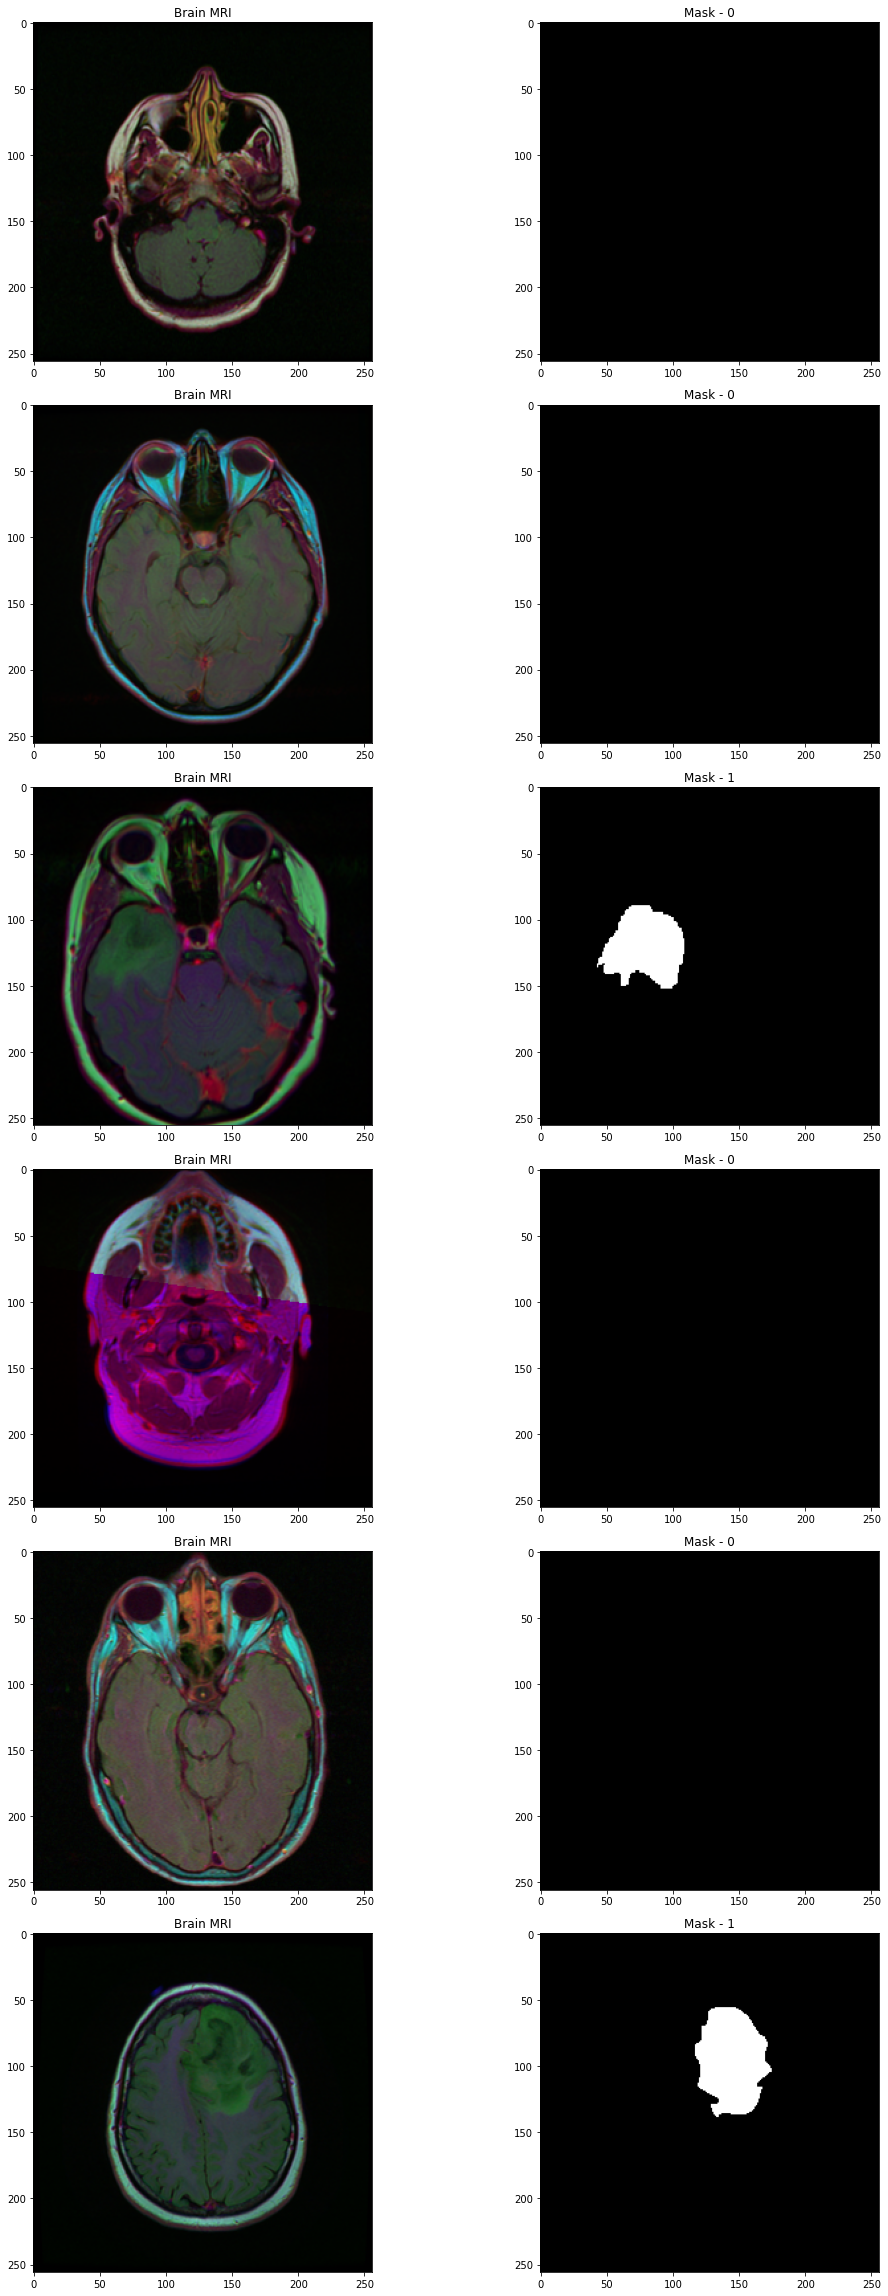

In [19]:
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread('../input/brain-mri/Brain_MRI/'+brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread('../input/brain-mri/Brain_MRI/'+brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

## Plotting 12 randomly selected MRI scan images from only sick patients followed by corresponding mask, both MRI image and the corresponding mask (in red color) on top of each other

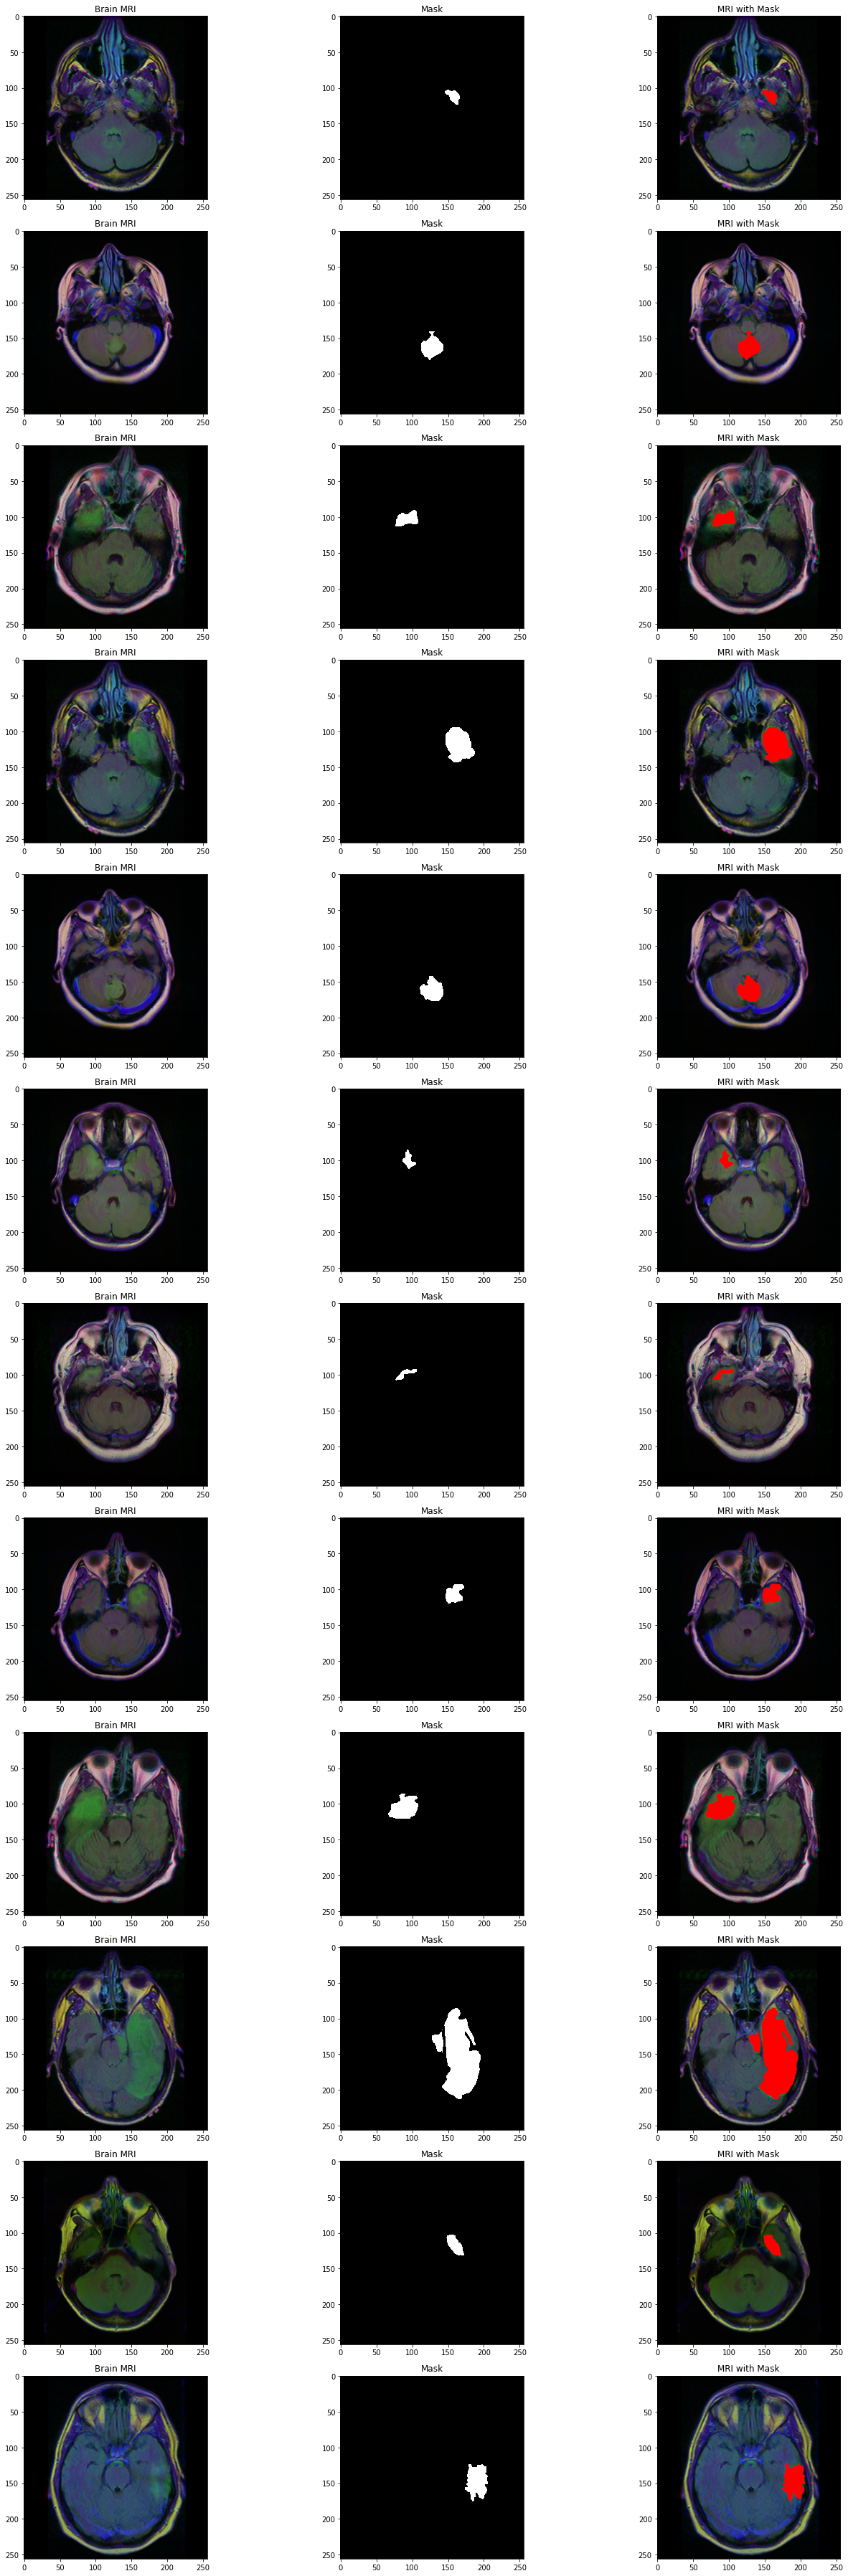

In [20]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread('../input/brain-mri/Brain_MRI/'+brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread('../input/brain-mri/Brain_MRI/'+brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()


# **Train a Classifier Model to Check if Tumor exists or not**

In [21]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [22]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [23]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [24]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.25)

In [25]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.25)


In [26]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= '../input/brain-mri/Brain_MRI/',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= '../input/brain-mri/Brain_MRI/',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= '../input/brain-mri/Brain_MRI/',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2210 validated image filenames belonging to 2 classes.
Found 736 validated image filenames belonging to 2 classes.
Found 983 validated image filenames belonging to 2 classes.


In [61]:
basemodel = DenseNet121(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [62]:
# freeze the model weights

for layer in basemodel.layers:
    layers.trainable = True

In [63]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [64]:
from tensorflow import keras

In [65]:
# compile the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [67]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 20, validation_data= valid_generator, validation_steps= valid_generator.n // 16)

Epoch 1/20
138/138 [==============================] - 33s 169ms/step - loss: 0.6024 - accuracy: 0.7735 - val_loss: 6.2629 - val_accuracy: 0.3995
Epoch 2/20
138/138 [==============================] - 21s 153ms/step - loss: 0.4432 - accuracy: 0.8209 - val_loss: 0.5343 - val_accuracy: 0.7799
Epoch 3/20
138/138 [==============================] - 21s 155ms/step - loss: 0.3751 - accuracy: 0.8500 - val_loss: 1.4737 - val_accuracy: 0.7188
Epoch 4/20
138/138 [==============================] - 21s 154ms/step - loss: 0.3537 - accuracy: 0.8642 - val_loss: 0.6875 - val_accuracy: 0.7011
Epoch 5/20
138/138 [==============================] - 21s 154ms/step - loss: 0.3573 - accuracy: 0.8510 - val_loss: 2.0370 - val_accuracy: 0.7459
Epoch 6/20
138/138 [==============================] - 21s 150ms/step - loss: 0.3031 - accuracy: 0.8778 - val_loss: 5.2420 - val_accuracy: 0.6726
Epoch 7/20
138/138 [==============================] - 21s 152ms/step - loss: 0.2938 - accuracy: 0.8879 - val_loss: 0.3878 - val_ac

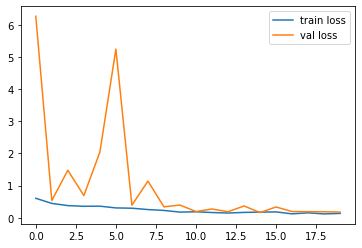

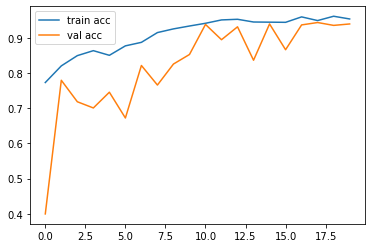

In [68]:
# plot the loss curve
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy curve
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [69]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

61/61 [==============================] - 4s 45ms/step


In [70]:
test_predict.shape

(976, 2)

In [71]:
test_predict

array([[1.3152396e-05, 9.9998689e-01],
       [9.9998116e-01, 1.8836165e-05],
       [2.9155321e-03, 9.9708444e-01],
       ...,
       [1.6989119e-04, 9.9983013e-01],
       [9.6514076e-01, 3.4859162e-02],
       [9.9999845e-01, 1.5553449e-06]], dtype=float32)

In [72]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
    predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [73]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

976

In [103]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

accuracy = accuracy_score(original, predict)
print('Testing Accuracy: ',accuracy)

Testing Accuracy:  0.9456967213114754


In [104]:
p = precision_score(original, predict)
print('Testing Precision: ',p)

Testing Precision:  0.9606557377049181


In [105]:
r = recall_score(original, predict)
print('Testing Recall: ',r)

Testing Recall:  0.8772455089820359


In [106]:
f1 = f1_score(original, predict)
print('Testing F1-Score: ',f1)

Testing F1-Score:  0.9170579029733958


<AxesSubplot:>

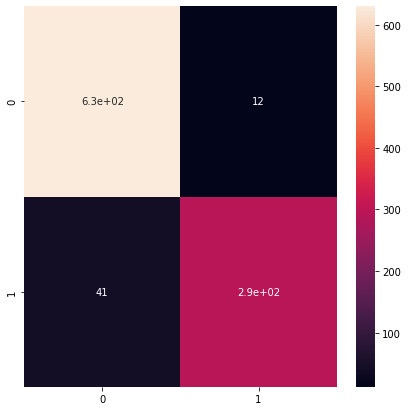

In [75]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [76]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       642
           1       0.96      0.88      0.92       334

   micro avg       0.95      0.95      0.95       976
   macro avg       0.95      0.93      0.94       976
weighted avg       0.95      0.95      0.95       976



/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [78]:
model.save_weights('best-classifier-densenet121-weights.h5')

In [83]:
import numpy as np
 
from sklearn.metrics import roc_auc_score, roc_curve
 
auc = np.round(roc_auc_score(original, predict), 3)
 
print("Auc for our sample data is {}". format(auc))

Auc for our sample data is 0.929


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:546: FutureWarning:

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.



In [91]:
original

array(['1', '0', '1', '1', '0', '0', '0', '0', '1', '0', '1', '0', '1',
       '0', '0', '1', '1', '0', '1', '1', '1', '0', '1', '0', '1', '1',
       '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0',
       '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0',
       '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0',
       '0', '1', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '0',
       '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1', '0', '1',
       '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '1',
       '0', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '1', '1',
       '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '0', '0',
       '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1', '1', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '1', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0',
       '1', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '0

In [92]:
predict

array(['1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1',
       '0', '0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '1',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0',
       '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0',
       '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '0',
       '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0',
       '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '1',
       '0', '0', '0', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0',
       '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '1', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '1', '1', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0',
       '1', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '0

In [94]:
original= '1' <= original
predict= '1' <= predict
fpr, tpr, thresholds = roc_curve(original, predict)

Text(0, 0.5, 'True Positive Rate')

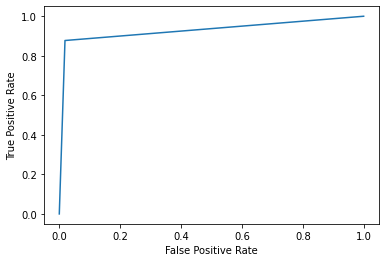

In [95]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [96]:
mat = confusion_matrix(original, predict)
mat

array([[630,  12],
       [ 41, 293]])

In [98]:
classes = ['Normal','Tumor']

In [99]:
import pandas as pd
cm_df = pd.DataFrame(mat, index = classes,
                     columns = classes
                    )

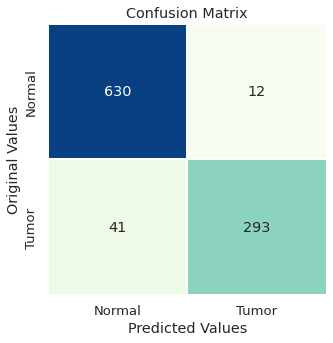

In [109]:
import seaborn as sns
plt.figure(figsize = (5,5))
sns.set(font_scale=1.2)
sns.heatmap(cm_df, annot = True,cbar=False,linewidth=2,fmt='d',cmap="GnBu")
plt.title('Confusion Matrix')
plt.ylabel('Original Values')
plt.xlabel('Predicted Values')
plt.savefig('Cm.png')
plt.show()